# **Analyse et prétraitement**

<div class="alert alert-info">
Nous allons ici nous focaliser sur l'analyse et le traitement de base des images. L'étape de data augmentation sera directement intégrée lors de l'entraînement de notre modèle.
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from PIL.ImageFilter import MedianFilter
from PIL.ImageEnhance import Contrast
from PIL.ImageOps import autocontrast, equalize

import numpy as np
from glob import glob
import os
import shutil  # Pour supprimer un dossier non vide



In [2]:
path = "dogs_small/"
#path = "simba/"
data_path = glob(path+'*/*.jp*')  # Récupération des chemins de tous les fichiers
#data_path = glob(path+'*.png')
suffixe = "_proc"

In [3]:
# Récupération des noms des dossiers (qui représentent les noms des labels)
# [len(path):] pour ne récupérer que les noms des dossiers, sans le chemin
list_labels = [os.path.dirname(dossier)[len(path):] for dossier in data_path]

# Récupération des noms de fichier (pour sauvegarde à la fin de nos traitements)
file_names = [os.path.basename(dossier) for dossier in data_path]

# Convertion des images en arrays
# img_array = [np.array(Image.open(ligne)) for ligne in data_path]

# Ouverture des images avec PIL.image
img_pil = [Image.open(ligne) for ligne in data_path]

In [4]:
def image_shower(img):
    # Si l'image entrée n'est pas un array,
    # on le convertit
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    # Générer et afficher l'histogramme à droite de l'image
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Afficher l'image à gauche
    ax1.imshow(np.array(img))  # Spécifier la colormap 'gray' pour que ça soit bien interprété comme une image en noir et blanc
    ax1.axis('off')  # Masquer les axes

    # Générer et afficher l'histogramme à droite
    ax2.hist(np.array(img).flatten(), bins=range(256))
    ax2.set_title('Histogramme')
    ax2.set_xlabel('Couleur')
    ax2.set_ylabel('Fréquence')

    # Générer et afficher l'histogramme à droite
    ax3.hist(np.array(img).flatten(), bins=range(256), density=True, cumulative=True)
    ax3.set_title('Histogramme cumulé normalisé')
    ax3.set_xlabel('Couleur')
    ax3.set_ylabel('Fréquence')

    plt.show()

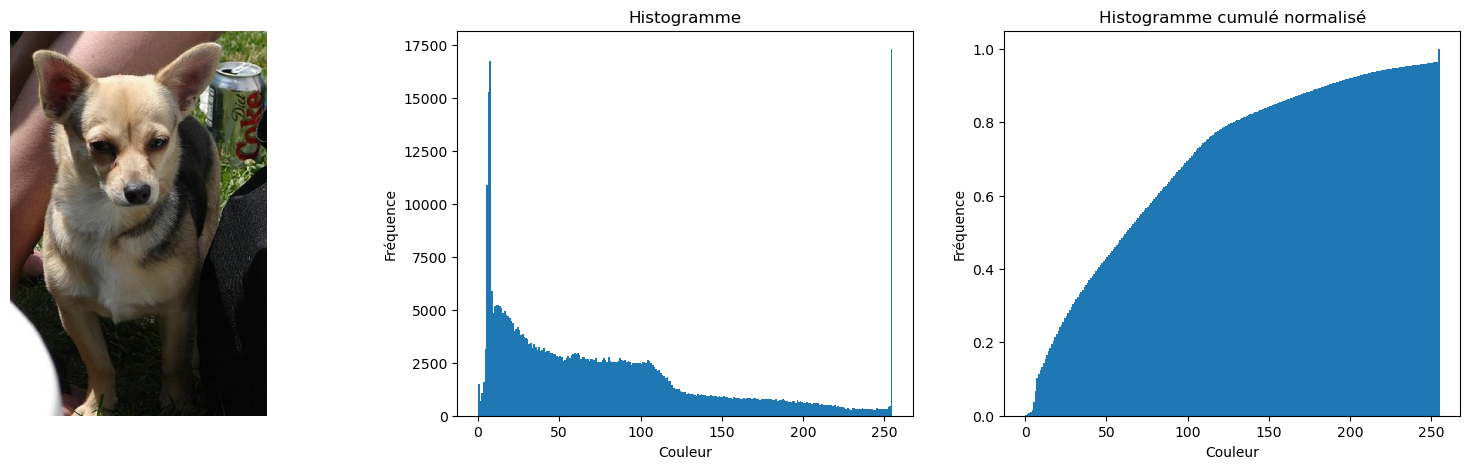

In [5]:
image_shower(img_pil[0])

In [6]:
for i in range(len(img_pil)):

    img = img_pil[i]

    # Ajout de contraste
    #img = Contrast(img).enhance(1.1)

    # Contrast auto : seulement si nécessaire
    img = autocontrast(img)
    
    # Equalization de l'histogramme 
    img = equalize(img)

    # Denoising léger
    #img = img.filter(MedianFilter(3))

    # Convertissez l'image de PIL en array NumPy
    img_pil[i] = img

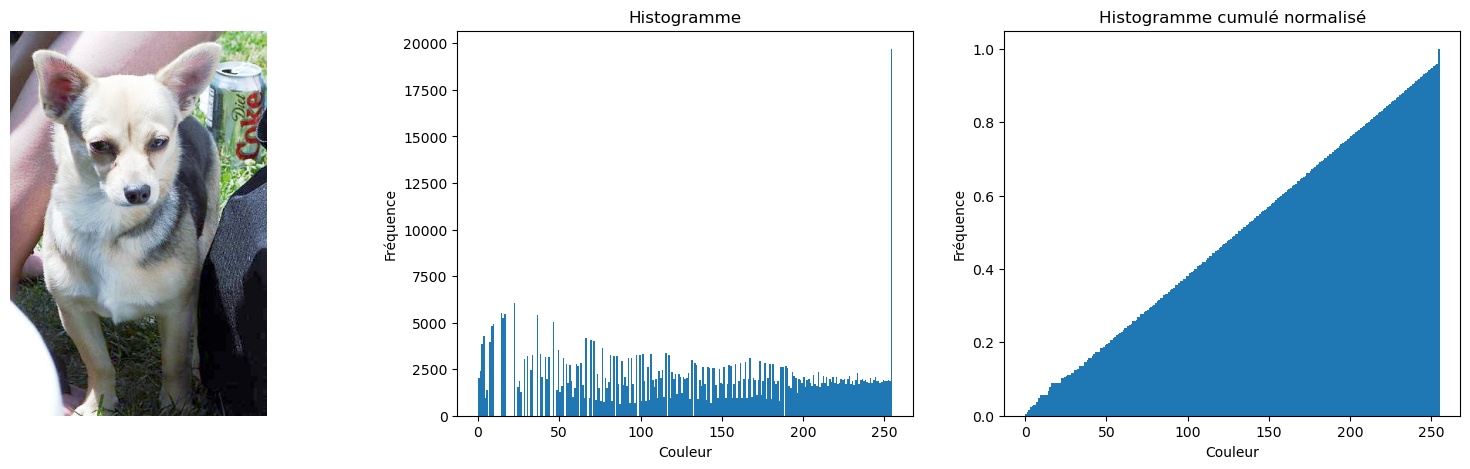

In [7]:
image_shower(img_pil[0])

In [8]:
# im = Image.fromarray(data["img_array"][0])
# im.save("your_file.jpeg")

In [9]:
save_file = False

if save_file:

    # Dossier de sauvegarde : même nom que celui d'origine + suffixe
    dossier = path[:-1]+suffixe

    # Si le dossier existe déjà (précédente sauvagarde)
    # suppression du dossier et de son contenu avec shutil
    if os.path.exists(path[:-1]+suffixe):
        shutil.rmtree(dossier)

    # Création du dossier
    os.mkdir(dossier)

    # Récupération du nom des labels
    unique_labels = list(set(list_labels))

    # Création des sous dossiers qui auront le nom de chaque label
    for i in range(len(unique_labels)):
        os.mkdir(path[:-1]+suffixe+"/"+unique_labels[i])

    # Enregistrement de chaque image dans son dossier respectif
    for i in range(len(img_pil)):
        img_pil[i].save(dossier+"/"+list_labels[i]+"/"+file_names[i])

# **ZCA Whitening**

In [10]:
# ZCA Whitening
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [11]:
X_train.shape

(60000, 28, 28)

C:\Users\Data Science\AppData\Roaming\Python\Python310\site-packages\keras\src\preprocessing\image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


-12.411183 0.003628775 17.104145


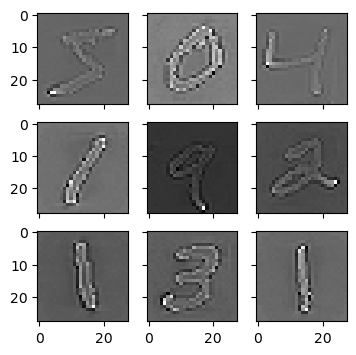

In [12]:
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zca_whitening=True)
# fit parameters from data
X_mean = X_train.mean(axis=0)
datagen.fit(X_train - X_mean)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train - X_mean, y_train, batch_size=9, shuffle=False):
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

## **Test avec un autre dataset**

In [13]:
import pickle
with open('zca/data_batch_1', 'rb') as input_file: 
    X = pickle.load(input_file, encoding='latin1')

X = X['data'][:1000]

In [14]:
X.shape

(1000, 3072)

In [15]:
X = X.reshape((-1, 3, 32, 32))
X.shape

(1000, 3, 32, 32)

In [16]:
X = X.transpose(0, 2, 3, 1)
X.shape

(1000, 32, 32, 3)

In [17]:
datagen2 = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zca_whitening=True)
# fit parameters from data
X_mean = X.mean(axis=0)
#X = X.astype('float32')
datagen2.fit(X - X_mean)


In [18]:
aaa = datagen2.flow(X - X_mean, batch_size=9, shuffle=False).next()

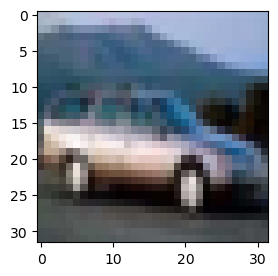

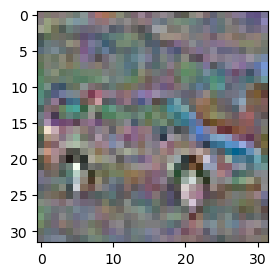

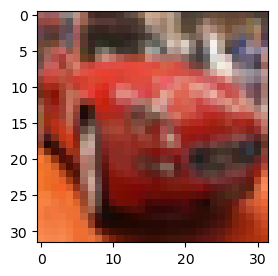

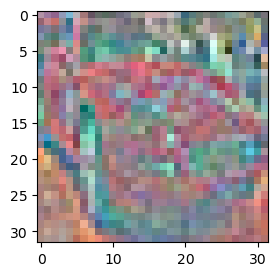

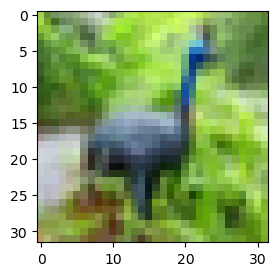

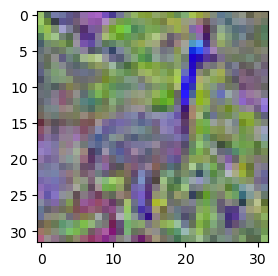

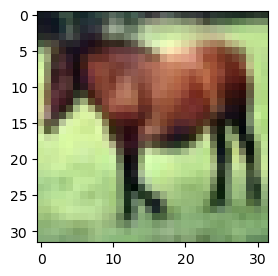

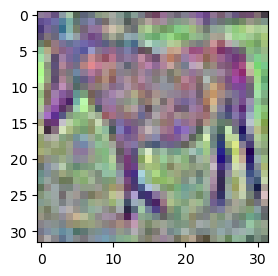

In [19]:
def show(i):
    i = i.reshape((32, 32, 3))
    m, M = i.min(), i.max()
   
    plt.figure(figsize = (3, 3))
    plt.imshow((i - m) / (M - m))
    plt.show()

for i in range(4, 8):
    show(X[i])
    show(aaa[i])